# Задание

In [ ]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации.
# 4. Вывести результат

# 1. Генерация набора данных

In [ ]:
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class SymbolSequenceGenerator:
    """Генератор последовательностей рукописных символов."""

    # Константы
    DEFAULT_SPACING = 30
    VERTICAL_PADDING = 10
    WHITE_PIXEL_VALUE = 255

    def __init__(self, data_path: str, train_size: float = 0.8, spacing: int = DEFAULT_SPACING):
        self.data_path = data_path
        self.train_size = train_size
        self.spacing = spacing

    def create_sequence_image(self, length: int) -> tuple[list[str], np.ndarray]:
        """Создает изображение с последовательностью символов.

        Args:
            length: Количество символов в последовательности

        Returns:
            Кортеж (нормализованная последовательность, изображение)
        """
        sequence, images = self._generate_list_of_images(length)
        if not images:
            raise ValueError("No images were generated — check dataset path and structure.")

        total_width = sum(img.shape[1] for img in images) + self.spacing * (len(images) - 1)
        max_height = max(img.shape[0] for img in images) + self.VERTICAL_PADDING

        # Белый фон
        sequence_image = np.ones((max_height, total_width), dtype=np.uint8) * self.WHITE_PIXEL_VALUE

        x_offset = 0
        for img in images:
            height, width = img.shape
            y_offset = (max_height - height) // 2  # Центрирование по вертикали
            sequence_image[y_offset:y_offset + height, x_offset:x_offset + width] = img
            x_offset += width + self.spacing

        return sequence, cv.bitwise_not(sequence_image)

    def _generate_list_of_images(self, length: int) -> tuple[list[str], list[np.ndarray]]:
        """Генерирует список изображений символов.

        Args:
            length: Количество символов

        Returns:
            Кортеж (нормализованная последовательность, список изображений)
        """
        available_symbols = self._get_available_symbols(self.data_path)
        sequence = random.choices(available_symbols, k=length)
        sequence_normalized = [self._normalize_symbol_name(sym) for sym in sequence]
        print(f"Generating: {sequence_normalized}")

        images = []
        for char in sequence:
            img = self._get_random_symbol_image(char)
            if img is not None:
                images.append(img)

        return sequence_normalized, images

    def _get_random_symbol_image(self, folder_name: str) -> np.ndarray | None:
        """Получает случайное изображение символа из папки.

        Args:
            folder_name: Имя папки с символами

        Returns:
            Изображение или None при ошибке
        """
        symbol_dir = os.path.join(self.data_path, folder_name)
        if not os.path.exists(symbol_dir):
            print(f"Directory does not exist: {symbol_dir}")
            return None

        images = sorted(os.listdir(symbol_dir))
        if not images:
            print(f"No images found in: {symbol_dir}")
            return None

        start_idx = int(len(images) * self.train_size)
        subset = images[start_idx:]
        if not subset:
            subset = images

        random_image = random.choice(subset)
        img_path = os.path.join(symbol_dir, random_image)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Failed to read image: {img_path}")
            return None

        return img

    @staticmethod
    def _normalize_symbol_name(symbol: str) -> str:
        """Нормализует имя символа.

        Args:
            symbol: Исходное имя символа

        Returns:
            Нормализованное имя
        """
        mapping = {'X': 'x', 'times': '*'}
        return mapping.get(symbol, symbol)

    @staticmethod
    def _get_available_symbols(data_path: str) -> list[str]:
        """Получает список доступных символов из папки данных.

        Args:
            data_path: Путь к папке с данными

        Returns:
            Список имен символов
        """
        if not os.path.exists(data_path):
            raise ValueError(f"Data path does not exist: {data_path}")

        subfolders = [
            name for name in next(os.walk(data_path))[1]
            if not name.startswith('.')
        ]
        return subfolders

In [7]:
!unzip ./drive/MyDrive/data.zip -d ./data

Выходные данные были обрезаны до нескольких последних строк (5000).
 extracting: ./data/y/exp69885.jpg   
 extracting: ./data/y/exp69903.jpg   
 extracting: ./data/y/exp69910.jpg   
 extracting: ./data/y/exp69911.jpg   
 extracting: ./data/y/exp69925.jpg   
 extracting: ./data/y/exp69927.jpg   
 extracting: ./data/y/exp69937.jpg   
 extracting: ./data/y/exp69948.jpg   
 extracting: ./data/y/exp69951.jpg   
 extracting: ./data/y/exp69997.jpg   
 extracting: ./data/y/exp70.jpg      
 extracting: ./data/y/exp70003.jpg   
 extracting: ./data/y/exp70103.jpg   
 extracting: ./data/y/exp70158.jpg   
 extracting: ./data/y/exp70164.jpg   
 extracting: ./data/y/exp70171.jpg   
 extracting: ./data/y/exp70176.jpg   
 extracting: ./data/y/exp70179.jpg   
 extracting: ./data/y/exp70200.jpg   
  inflating: ./data/y/exp70203.jpg   
  inflating: ./data/y/exp70209.jpg   
 extracting: ./data/y/exp70247.jpg   
 extracting: ./data/y/exp7025.jpg    
 extracting: ./data/y/exp70253.jpg   
 extracting: ./data/

In [14]:
path_to_folder = './data'
generator = SymbolSequenceGenerator(path_to_folder)

In [15]:
def show_image(image: np.ndarray, figsize: tuple[int, int] = (10, 8)) -> None:
    """Отображает изображение.

    Args:
        image: Изображение для отображения
        figsize: Размер фигуры
    """
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Generating: ['(', 'x', '2', '1', ')', '0', '3', '9', '+', '4']


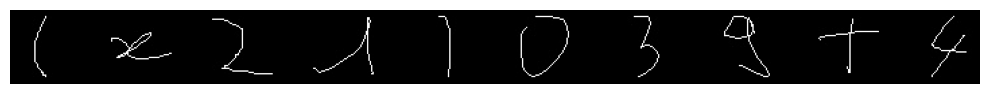

In [16]:
_, sequence_image = generator.create_sequence_image(10)
show_image(sequence_image)

# 2. Тренировка моделей (k ближайших соседей)

In [17]:
!pip install scikit-learn

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [19]:
class DataLoader:
    """Загрузчик данных для обучения классификатора."""

    RANDOM_STATE = 42

    def load_data(self, data_path: str, train_ratio: float = 0.8) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """Загружает данные из папки и разделяет на train/test.

        Args:
            data_path: Путь к папке с данными
            train_ratio: Доля данных для обучения

        Returns:
            Кортеж (X_train, X_test, y_train, y_test)
        """
        features, labels = [], []
        symbols = self._get_available_symbols(data_path)
        print(f"Found symbols: {symbols}")

        for symbol in symbols:
            symbol_dir = os.path.join(data_path, symbol)
            if not os.path.exists(symbol_dir):
                print(f"\tWarning: directory does not exist for symbol '{symbol}'")
                continue

            images = sorted(os.listdir(symbol_dir))
            if not images:
                print(f"\tWarning: no images found for symbol '{symbol}'")
                continue

            label = self._normalize_symbol_name(symbol)
            for img_name in images:
                img_path = os.path.join(symbol_dir, img_name)
                img_vector = self._load_image(img_path)
                if img_vector is None:
                    print(f"\tWarning: failed to read image {img_path}")
                    continue
                features.append(img_vector)
                labels.append(label)

        features_array = np.array(features)
        labels_array = np.array(labels)
        print(f"Total images loaded: {len(features_array)}")

        # Разделение на train/test
        X_train, X_test, y_train, y_test = train_test_split(
            features_array, labels_array, train_size=train_ratio,
            stratify=labels_array, random_state=self.RANDOM_STATE
        )
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

        return X_train, X_test, y_train, y_test

    @staticmethod
    def _get_available_symbols(data_path: str) -> list[str]:
        """Получает список доступных символов.

        Args:
            data_path: Путь к папке с данными

        Returns:
            Список имен символов
        """
        if not os.path.exists(data_path):
            raise ValueError(f"Data path does not exist: {data_path}")
        return [name for name in next(os.walk(data_path))[1] if not name.startswith('.')]

    @staticmethod
    def _normalize_symbol_name(symbol: str) -> str:
        """Нормализует имя символа.

        Args:
            symbol: Исходное имя символа

        Returns:
            Нормализованное имя
        """
        mapping = {'X': 'x', 'times': '*'}
        return mapping.get(symbol, symbol)

    @staticmethod
    def _load_image(img_path: str) -> np.ndarray | None:
        """Загружает изображение и преобразует в вектор.

        Args:
            img_path: Путь к изображению

        Returns:
            Вектор изображения или None при ошибке
        """
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        if img is None:
            return None
        return img.flatten()

In [20]:
class ModelComparator:
    """Компаратор для сравнения моделей KNN с разными параметрами."""

    ACCURACY_PRECISION = 4

    def __init__(self):
        self.model_results: dict[str, dict] = {}

    def add_model_result(self, model_name: str, model: KNeighborsClassifier, accuracy: float) -> None:
        """Добавляет результат модели.

        Args:
            model_name: Имя модели
            model: Обученная модель
            accuracy: Точность модели
        """
        self.model_results[model_name] = {
            'model': model,
            'accuracy': accuracy
        }

    def compare_models(self) -> tuple[str | None, KNeighborsClassifier | None, float | None]:
        """Сравнивает модели и возвращает лучшую.

        Returns:
            Кортеж (имя лучшей модели, модель, точность)
        """
        for name, result in sorted(self.model_results.items()):
            print(f"{name}: Accuracy = {result['accuracy']:.{self.ACCURACY_PRECISION}f}")

        if self.model_results:
            best_name = max(self.model_results.keys(),
                          key=lambda x: self.model_results[x]['accuracy'])
            best_result = self.model_results[best_name]
            return best_name, best_result['model'], best_result['accuracy']

        return None, None, None

    def train_and_evaluate_models(self, X_train: np.ndarray, X_test: np.ndarray,
                                   y_train: np.ndarray, y_test: np.ndarray,
                                   k_values: list[int] = None) -> tuple[str, KNeighborsClassifier, float]:
        """Обучает и оценивает несколько моделей KNN.

        Args:
            X_train: Обучающие признаки
            X_test: Тестовые признаки
            y_train: Обучающие метки
            y_test: Тестовые метки
            k_values: Список значений k для KNN (по умолчанию [1, 3, 5, 7])

        Returns:
            Кортеж (имя лучшей модели, модель, точность)
        """
        if k_values is None:
            k_values = [1, 3, 5, 7]

        for k in k_values:
            knn_model = KNeighborsClassifier(n_neighbors=k)
            knn_model.fit(X_train, y_train)
            predictions = knn_model.predict(X_test)
            accuracy = accuracy_score(y_test, predictions)
            model_name = f"KNN-{k}"
            self.add_model_result(model_name, knn_model, accuracy)
            print(f"{model_name} accuracy: {accuracy:.{self.ACCURACY_PRECISION}f}")

        return self.compare_models()

In [21]:
data_loader = DataLoader()
X_train, X_test, y_train, y_test = data_loader.load_data("./data")

Found symbols: ['h', ')', 'w', '9', '(', '+', ',', 'X', 't', '5', 'times', '2', 'y', '0', '6', '8', '7', '-', '3', '4', '1']
Total images loaded: 225291
Train size: 180232, Test size: 45059


In [ ]:
comparator = ModelComparator()

# Обучаем и сравниваем модели с разными значениями k
best_model_name, best_knn_model, best_accuracy = comparator.train_and_evaluate_models(
    X_train, X_test, y_train, y_test, k_values=[1, 3, 5, 7]
)
print(f"\nBest model: {best_model_name} with accuracy {best_accuracy:.4f}")

# 3. Распознание

Generating: ['6', '3', '7', 't', '9', '2', 'y', '0', '6', 'w']


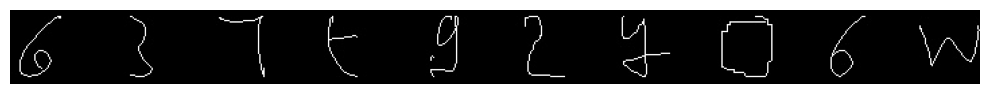

In [ ]:
# 1. Генерация изображения с последовательностью символов
sequence, gray_image = generator.create_sequence_image(10)
rgb_image = cv.cvtColor(gray_image, cv.COLOR_GRAY2RGB)

show_image(gray_image)

Thresh shape: (55, 720, 3)


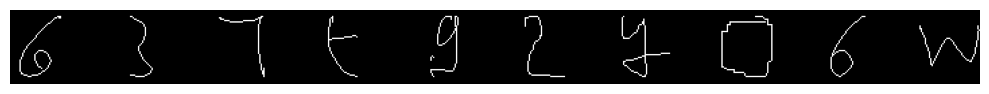

In [ ]:
# 2. Выделение объектов (пороговая обработка)
# Константы для пороговой обработки
THRESHOLD_VALUE = 127
MAX_VALUE = 255

_, binary_image = cv.threshold(rgb_image, THRESHOLD_VALUE, MAX_VALUE, 0)
print("Binary image shape:", binary_image.shape)
binary_image = np.uint8(binary_image)

show_image(binary_image)

In [ ]:
# Поиск контуров символов
contours, hierarchy = cv.findContours(binary_image[:, :, 0], cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

1: [7, 5, 31, 45]
2: [89, 5, 17, 45]
3: [155, 5, 34, 45]
4: [236, 5, 22, 45]
5: [312, 5, 21, 45]
6: [382, 5, 30, 45]
7: [454, 5, 36, 45]
8: [528, 5, 38, 45]
9: [609, 5, 26, 45]
10: [675, 12, 45, 30]


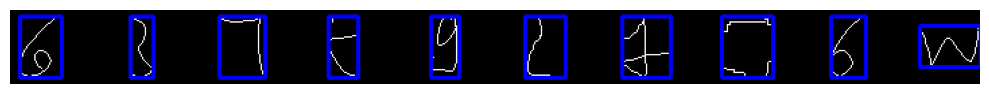

In [ ]:
# Константы для фильтрации контуров
MIN_CONTOUR_AREA = 50
RECTANGLE_COLOR = (0, 0, 255)
RECTANGLE_THICKNESS = 2

bounding_boxes = []
for contour in contours:
    area = cv.contourArea(contour)
    x, y, width, height = cv.boundingRect(contour)
    if width * height > MIN_CONTOUR_AREA:
        cv.rectangle(rgb_image, (x, y), (x + width, y + height),
                     RECTANGLE_COLOR, RECTANGLE_THICKNESS)
        bounding_boxes.append([x, y, width, height])

# Сортировка по координате x (слева направо)
bounding_boxes.sort(key=lambda box: box[0])

# Вывод координат найденных символов
for idx, box in enumerate(bounding_boxes):
    print(f'{idx + 1}:', box)

show_image(rgb_image)

In [ ]:
# Константы для обработки изображений
DEFAULT_TARGET_SIZE = (45, 45)
DEFAULT_THRESHOLD = 10

def pad_to_size(image: np.ndarray, target_size: tuple[int, int] = DEFAULT_TARGET_SIZE) -> np.ndarray:
    """Добавляет отступы к изображению до целевого размера с центрированием.

    Args:
        image: Входное изображение
        target_size: Целевой размер (высота, ширина)

    Returns:
        Изображение с отступами
    """
    height, width = image.shape
    target_height, target_width = target_size

    # Создаем черное изображение (нули) нужного размера
    padded = np.zeros(target_size, dtype=np.uint8)
    y_start = (target_height - height) // 2
    x_start = (target_width - width) // 2

    padded[y_start:y_start + height, x_start:x_start + width] = image
    return padded

def pad_and_crop(image: np.ndarray, target_size: tuple[int, int] = DEFAULT_TARGET_SIZE,
                 threshold: int = DEFAULT_THRESHOLD) -> np.ndarray:
    """Обрезает черные края и добавляет отступы до целевого размера.

    Args:
        image: Входное изображение
        target_size: Целевой размер (высота, ширина)
        threshold: Порог для определения черных пикселей

    Returns:
        Обработанное изображение
    """
    height, width = image.shape
    target_height, target_width = target_size

    if height == target_height and width == target_width:
        return image

    if height > target_height or width > target_width:
        # Обрезаем черные края
        non_zero_rows = np.where(np.max(image, axis=1) > threshold)[0]
        non_zero_cols = np.where(np.max(image, axis=0) > threshold)[0]

        if len(non_zero_rows) > 0 and len(non_zero_cols) > 0:
            y1, y2 = non_zero_rows[0], non_zero_rows[-1] + 1
            x1, x2 = non_zero_cols[0], non_zero_cols[-1] + 1
            image = image[y1:y2, x1:x2]

        # Масштабируем
        height, width = image.shape
        scale = min(target_height / height, target_width / width)
        if scale < 1.0:
            new_height, new_width = int(height * scale), int(width * scale)
            image = cv.resize(image, (new_width, new_height))

    return pad_to_size(image, target_size)

In [ ]:
# Константы для предобработки символов
VERTICAL_PADDING = 2
HORIZONTAL_PADDING = 30
LEFT_OFFSET = 15

processed_images = []
for x, y, width, height in bounding_boxes:
    char_image = gray_image[y:y + height, x:x + width]

    # Создаем базовое изображение с отступами
    base_height = char_image.shape[0] + VERTICAL_PADDING
    base_width = char_image.shape[1] + HORIZONTAL_PADDING
    base_image = np.zeros((base_height, base_width), dtype=np.uint8)
    base_image[1:char_image.shape[0] + 1, LEFT_OFFSET:char_image.shape[1] + LEFT_OFFSET] = char_image

    # Обработка и нормализация размера
    base_padded = pad_and_crop(base_image)
    processed_images.append(base_padded)

In [ ]:
# 3. Применить k-NN для решения задачи классификации
predictions = []
for char_image in processed_images:
    # Инвертируем изображение (символы должны быть белыми на черном фоне)
    img_vector = cv.bitwise_not(char_image).flatten()
    prediction = best_knn_model.predict([img_vector])[0]
    predictions.append(prediction)

In [ ]:
# 4. Вывести результат
ACCURACY_PRECISION = 4

predicted_sequence_str = ' '.join(predictions)
expected_sequence_str = ' '.join(sequence)
correct_predictions = sum(1 for pred, expected in zip(predictions, sequence) if pred == expected)
accuracy = round(correct_predictions / len(sequence), ACCURACY_PRECISION)

print(f"Predicted sequence: {predicted_sequence_str}")
print(f"Expected sequence: {expected_sequence_str}")
print(f"Accuracy: {accuracy}")

Predicted sequence: 6 3 7 t 9 2 y 0 6 w
Expected sequence: 6 3 7 t 9 2 y 0 6 w
Accuracy: 1.0
